In [1]:
# generally useful imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scipy.stats as  sc

import geopandas as gpd
from matplotlib.collections import PatchCollection

# For interactive plots
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

In [2]:
livestock = pd.read_csv('data/Production_Livestock_E_All_Data_(Normalized).csv', encoding='iso-8859-1')
beehives = livestock.loc[livestock['Item'] == 'Beehives', ['Area', 'Value', 'Year']]
beehives.columns = ['Area', 'Beehives', 'Year']
beehives.reset_index(drop=True, inplace=True)
beehives.head()

,Area,Beehives,Year
0,Albania,95100.0,1961
1,Albania,92800.0,1962
2,Albania,83500.0,1963
3,Albania,96500.0,1964
4,Albania,109800.0,1965


In [76]:
beehives['Year'] = pd.to_datetime(beehives['Year'], format="%Y")
bw = beehives[beehives['Area'] == 'World']
bw = bw.reset_index();
bw = bw.drop(['Area', 'index'], axis='columns')
bw = bw.set_index(['Year'])
plt.plot(bw)

In [80]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(8).mean()
    rolstd = timeseries.rolling(8).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    print("Results of Dickey-Fuller Test")
    dftest = adfuller(timeseries.Beehives.values, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

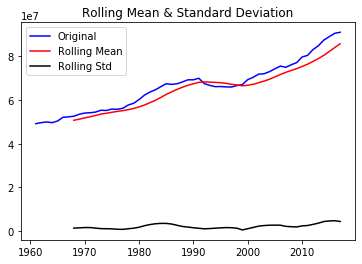

Results of Dickey-Fuller Test
Test Statistic                  0.361426
p-value                         0.979994
#Lags Used                      2.000000
Number of Observations Used    54.000000
Critical Value (1%)            -3.557709
Critical Value (5%)            -2.916770
Critical Value (10%)           -2.596222
dtype: float64


In [81]:
test_stationarity(bw)

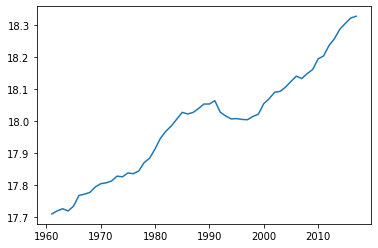

In [82]:
bw_log = np.log(bw)
plt.plot(bw_log)

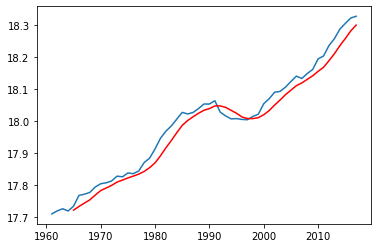

In [83]:
moving_avg = bw_log.rolling(5).mean()
plt.plot(bw_log)
plt.plot(moving_avg, color='red')

In [84]:
bw_log_moving_avg_diff = bw_log - moving_avg
bw_log_moving_avg_diff.dropna(inplace=True)
bw_log_moving_avg_diff.head(12)

,Beehives
Year,
1965-01-01,0.012273
1966-01-01,0.034263
1967-01-01,0.027789
1968-01-01,0.023078
1969-01-01,0.025188
1970-01-01,0.021259
1971-01-01,0.016239
1972-01-01,0.013685
1973-01-01,0.018628


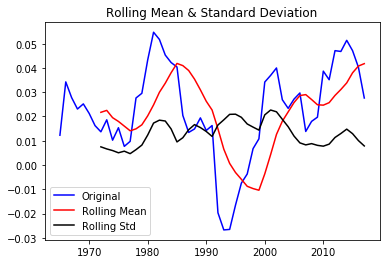

Results of Dickey-Fuller Test
Test Statistic                 -2.828974
p-value                         0.054253
#Lags Used                      2.000000
Number of Observations Used    50.000000
Critical Value (1%)            -3.568486
Critical Value (5%)            -2.921360
Critical Value (10%)           -2.598662
dtype: float64


In [85]:
test_stationarity(bw_log_moving_avg_diff)

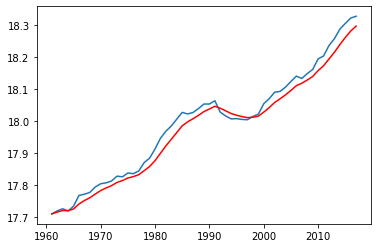

In [86]:
expweightend_avg = bw_log.ewm(span=5).mean()
plt.plot(bw_log)
plt.plot(expweightend_avg, color='red')

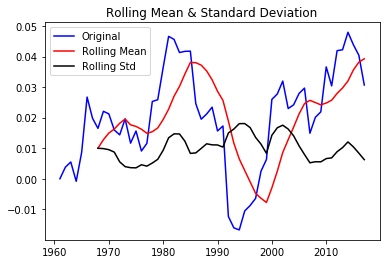

Results of Dickey-Fuller Test
Test Statistic                 -2.441367
p-value                         0.130400
#Lags Used                      2.000000
Number of Observations Used    54.000000
Critical Value (1%)            -3.557709
Critical Value (5%)            -2.916770
Critical Value (10%)           -2.596222
dtype: float64


In [87]:
bw_log_ewma_diff = bw_log - expweightend_avg
test_stationarity(bw_log_ewma_diff)

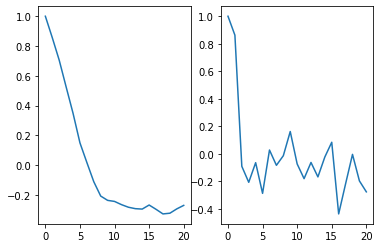

In [88]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf

lag_acf = acf(bw_log_ewma_diff, nlags=20)
lag_pacf = pacf(bw_log_ewma_diff, nlags=20, method='ols')

plt.subplot(121)
plt.plot(lag_acf)

plt.subplot(122)
plt.plot(lag_pacf)

/home/anel/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/home/anel/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


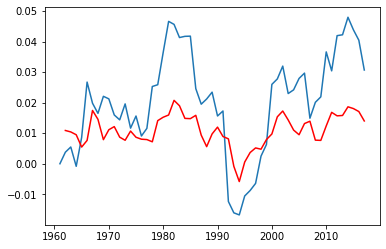

In [89]:
model = ARIMA(bw_log, order = (2,1,0))
results_AR = model.fit(dip=-1)
plt.plot(bw_log_ewma_diff)
plt.plot(results_AR.fittedvalues, color='red')

/home/anel/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/home/anel/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


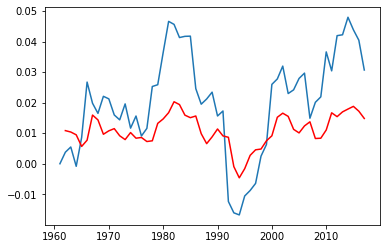

In [100]:
model = ARIMA(bw_log, order=(0,1,2))
resultsMA = model.fit(disp=-1)
plt.plot(bw_log_ewma_diff)
plt.plot(resultsMA.fittedvalues, color='red')

In [91]:
predictions_ARIMA_diff = pd.Series(resultsMA.fittedvalues, copy=True)

In [92]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()

In [93]:
predictions_ARIMA_diff_cumsum_log = pd.Series(bw_log.loc['1961-01-01'].Beehives, index = bw_log.index)
predictions_ARIMA_diff_cumsum_log = predictions_ARIMA_diff_cumsum_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)

In [94]:
predictions_ARIMA_diff_cumsum_log.head()

Year
1961-01-01    17.710865
1962-01-01    17.721843
1963-01-01    17.732377
1964-01-01    17.742082
1965-01-01    17.747893
dtype: float64

In [95]:
predictions_ARIMA = np.exp(predictions_ARIMA_diff_cumsum_log)

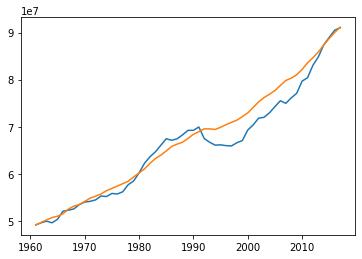

In [96]:
plt.plot(bw)
plt.plot(predictions_ARIMA)

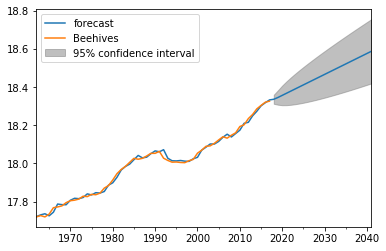

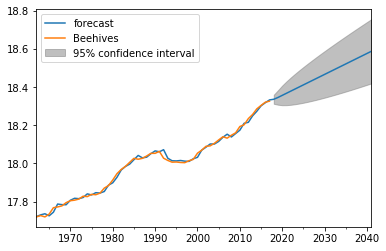

In [97]:
resultsMA.plot_predict(1,80)

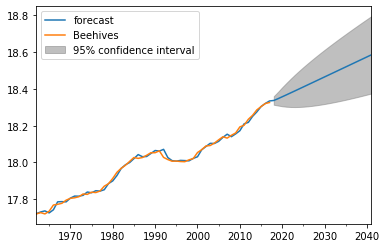

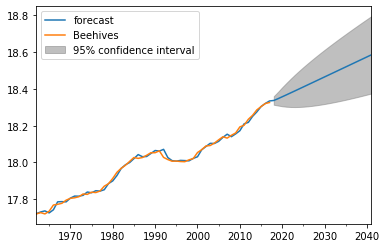

In [98]:
results_AR.plot_predict(1,80)

## New try (https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7)

In [3]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()


In [4]:
bw

NameError: name 'bw' is not defined

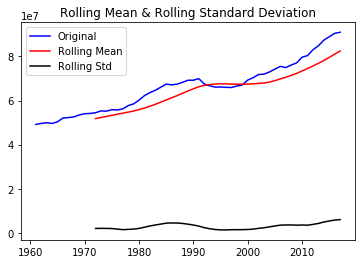

In [83]:
rolling_mean = bw.rolling(window = 12).mean()
rolling_std = bw.rolling(window = 12).std()
plt.plot(bw, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation')
plt.show()

As you can see, the rolling mean and rolling standard deviation increase with time. Therefore, we can conclude that the time series is not stationary.

In [84]:
result = adfuller(bw['Beehives'])
print('ADF Statistic: {}'.format(result[0]))
print('p-value: {}'.format(result[1]))
print('Critical Values:')
for key, value in result[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: 0.3614260865455343
p-value: 0.9799936702740074
Critical Values:
	1%: -3.55770911573439
	5%: -2.9167703434435808
	10%: -2.59622219478738


The ADF Statistic is far from the critical values and the p-value is greater than the threshold (0.05). Thus, we can conclude that the time series is not stationary.

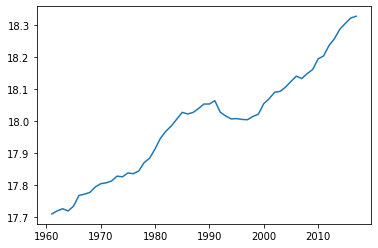

In [85]:
bw_log = np.log(bw)
plt.plot(bw_log)

Let’s create a function to run the two tests which determine whether a given time series is stationary.

In [86]:
def get_stationarity(timeseries):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=8).mean()
    rolling_std = timeseries.rolling(window=8).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey–Fuller test:
    result = adfuller(timeseries['Beehives'])
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

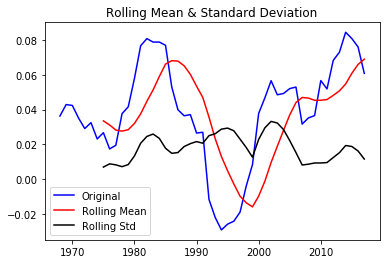

ADF Statistic: -2.946783572766816
p-value: 0.04017193408588419
Critical Values:
	1%: -3.5778480370438146
	5%: -2.925338105429433
	10%: -2.6007735310095064


In [87]:
rolling_mean = bw_log.rolling(window=8).mean()
bw_log_minus_mean = bw_log - rolling_mean
bw_log_minus_mean.dropna(inplace=True)
get_stationarity(bw_log_minus_mean)

As we can see, after subtracting the mean, the rolling mean and standard deviation are approximately horizontal. The p-value is below the threshold of 0.05 and the ADF Statistic is close to the critical values. Therefore, the time series is stationary.

Applying exponential decay is another way of transforming a time series such that it is stationary.

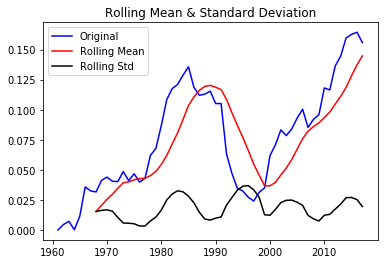

ADF Statistic: -1.8162591606436527
p-value: 0.3724198708117765
Critical Values:
	1%: -3.55770911573439
	5%: -2.9167703434435808
	10%: -2.59622219478738


In [88]:
rolling_mean_exp_decay = bw_log.ewm(halflife=8, min_periods=0, adjust=True).mean()
bw_log_exp_decay = bw_log - rolling_mean_exp_decay
bw_log_exp_decay.dropna(inplace=True)
get_stationarity(bw_log_exp_decay)

Exponential decay performed worse than subtracting the rolling mean. However, it is still more stationary than the original.

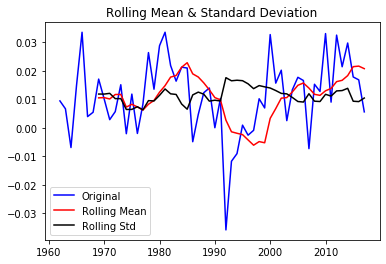

ADF Statistic: -3.2106574590034906
p-value: 0.01937601244072977
Critical Values:
	1%: -3.55770911573439
	5%: -2.9167703434435808
	10%: -2.59622219478738


In [89]:
bw_log_shift = bw_log - bw_log.shift()
bw_log_shift.dropna(inplace=True)
get_stationarity(bw_log_shift)

Time shifting performed worse than subtracting the rolling mean. However, it is still more stationary than the original.

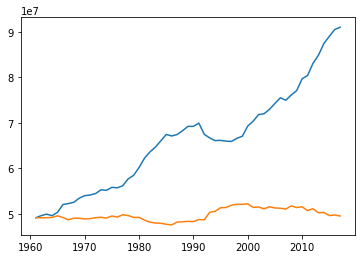

In [90]:
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(bw_log['Beehives'].iloc[0], index=bw_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(bw)
plt.plot(predictions_ARIMA)

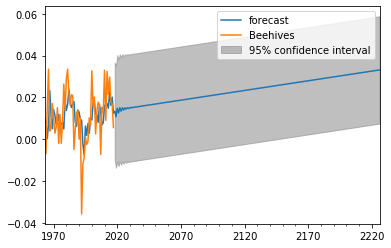

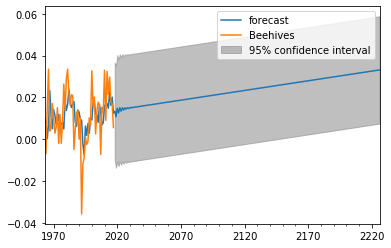

In [121]:
results.plot_predict(1,264)

## Next one (https://towardsdatascience.com/arima-forecasting-in-python-90d36c2246d3)

In [1]:
# generally useful imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scipy.stats as  sc

import geopandas as gpd
from matplotlib.collections import PatchCollection

# For interactive plots
import ipywidgets as widgets
from ipywidgets import interact, interact_manual

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA


In [2]:
livestock = pd.read_csv('data/Production_Livestock_E_All_Data_(Normalized).csv', encoding='iso-8859-1')
beehives = livestock.loc[livestock['Item'] == 'Beehives', ['Area', 'Value', 'Year']]
beehives.columns = ['Area', 'Beehives', 'Year']
beehives.reset_index(drop=True, inplace=True)
beehives.head()

,Area,Beehives,Year
0,Albania,95100.0,1961
1,Albania,92800.0,1962
2,Albania,83500.0,1963
3,Albania,96500.0,1964
4,Albania,109800.0,1965


/home/anel/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


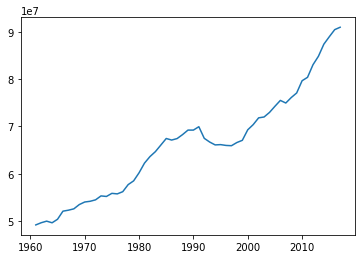

In [3]:
beehives['Year'] = pd.to_datetime(beehives['Year'], format="%Y")
bw = beehives[beehives['Area'] == 'World']
bw = bw.reset_index();
bw = bw.drop(['Area', 'index'], axis='columns')
bw = bw.set_index(['Year'])
plt.plot(bw)

In [4]:
timeseries = bw['Beehives'].copy()
print("p-value:", adfuller(timeseries.dropna())[1])


p-value: 0.9799936702740074


The p-value is greater than the significance level 0.05 so it is not stationary and differencing is as such needed, ie. d > 0.

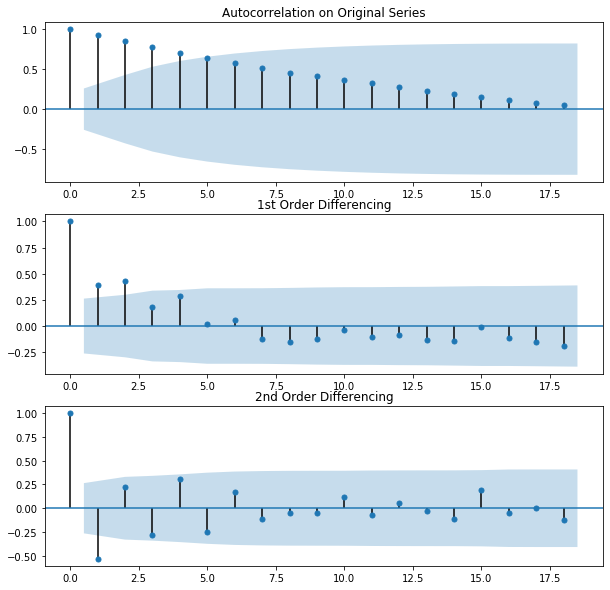

In [5]:
fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(311)
fig = plot_acf(timeseries, ax=ax1,
               title="Autocorrelation on Original Series") 
ax2 = fig.add_subplot(312)
fig = plot_acf(timeseries.diff().dropna(), ax=ax2, 
               title="1st Order Differencing")
ax3 = fig.add_subplot(313)
fig = plot_acf(timeseries.diff().diff().dropna(), ax=ax3, 
               title="2nd Order Differencing")

/home/anel/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1358: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


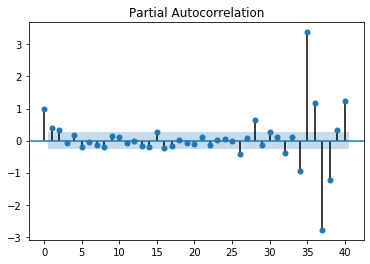

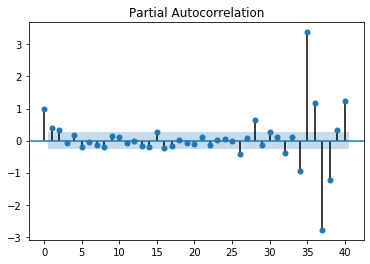

In [6]:
plot_pacf(timeseries.diff().dropna(), lags=40)


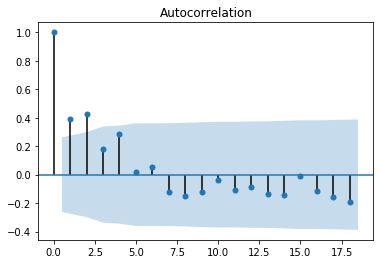

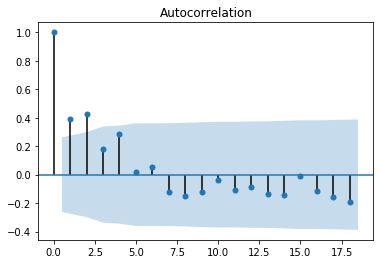

In [7]:
plot_acf(timeseries.diff().dropna())

q = 3 bc three lags above significance level

/home/anel/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/home/anel/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


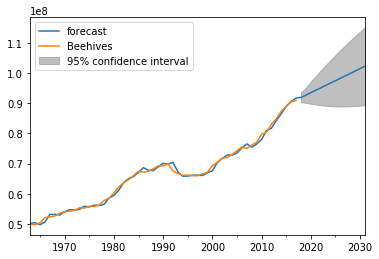

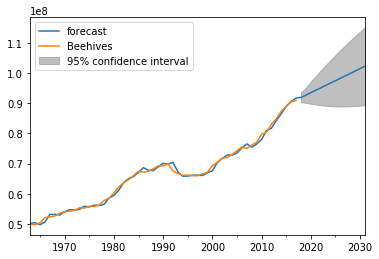

In [8]:
model = ARIMA(timeseries, order=(2, 2, 1))
results = model.fit()
results.plot_predict(2, 70)

### Redoo for data up to 2010 predict then show +2010 in different color and lay the blue line below

https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/

/home/anel/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/home/anel/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


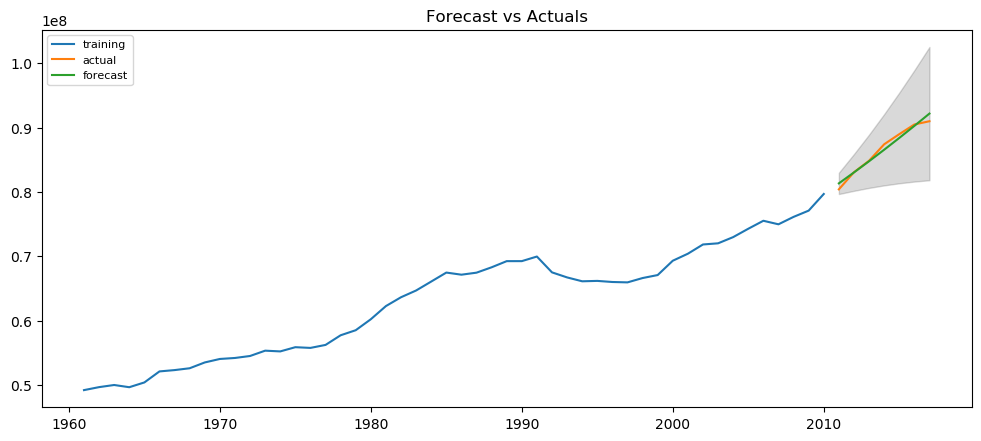

In [56]:
train = bw.Beehives[:50]
test = bw.Beehives[50:]

# Build Model
model = ARIMA(train, order=(1, 2, 1))  
fitted = model.fit(disp=-1)  

# Forecast
fc, se, conf = fitted.forecast(7, alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test.index)
lower_series = pd.Series(conf[:, 0], index=test.index)
upper_series = pd.Series(conf[:, 1], index=test.index)

# Plot
plt.figure(figsize=(12,5), dpi=100)
plt.plot(train, label='training')
plt.plot(test, label='actual')
plt.plot(fc_series, label='forecast')
plt.fill_between(lower_series.index, lower_series, upper_series, 
                 color='k', alpha=.15)
plt.title('Forecast vs Actuals')
plt.legend(loc='upper left', fontsize=8)
plt.show()

/home/anel/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)
/home/anel/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency AS-JAN will be used.
  % freq, ValueWarning)


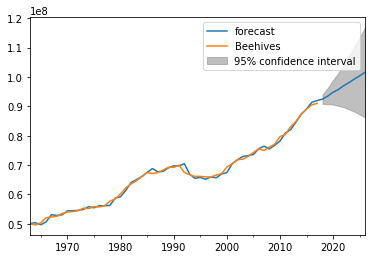

In [54]:
model = ARIMA(bw.Beehives, order=(3, 2, 1))  
fitted = model.fit(disp=-1) 
fitted.plot_predict(2, 65);

## Automatic arima model

In [14]:
import pmdarima as pm

In [15]:
model = pm.auto_arima(bw.Beehives, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

Fit ARIMA: order=(1, 2, 1) seasonal_order=(0, 0, 0, 0); AIC=1688.820, BIC=1696.849, Fit time=0.171 seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 0, 0, 0); AIC=1681.462, BIC=1685.476, Fit time=0.009 seconds
Fit ARIMA: order=(1, 2, 0) seasonal_order=(0, 0, 0, 0); AIC=1686.284, BIC=1692.306, Fit time=0.017 seconds
Fit ARIMA: order=(0, 2, 1) seasonal_order=(0, 0, 0, 0); AIC=1685.784, BIC=1691.806, Fit time=0.021 seconds
Fit ARIMA: order=(0, 2, 0) seasonal_order=(0, 0, 0, 0); AIC=1679.497, BIC=1681.504, Fit time=0.004 seconds
Total fit time: 0.242 seconds


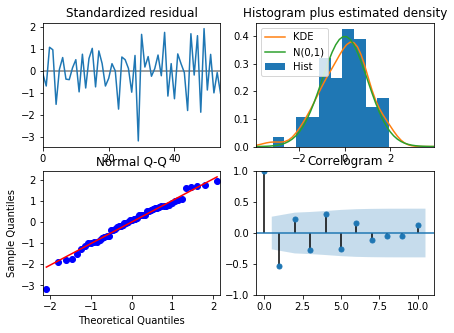

In [16]:
model.plot_diagnostics(figsize=(7,5))
plt.show()

In [33]:
bw_noIndex = bw.reset_index()
del bw_noIndex['Year']

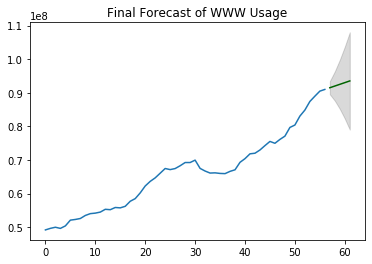

In [36]:
# Forecast
n_periods = 5
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(bw_noIndex.Beehives), len(bw_noIndex.Beehives)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(bw_noIndex.Beehives)
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)

plt.title("Final Forecast of WWW Usage")
plt.show()